### 1.2) Preprocessing - Plaque Detection and Image Cropping

The previous dataset color normalizes the whole slide images and regularly tiles them to 1536 by 1536 pixel images. To generate the plaque dataset for expert annotation, we apply an HSV filter and smoothing to detect candidate plaques. Each candidate is center cropped to provide a 256 x 256 image, and bounding coordinates are generated and written to CSV.

In [3]:
import csv
import glob, os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure

from tqdm import tqdm

In [4]:
# Set random seeds
np.random.seed(42)

In [5]:
IMG_DIR = 'data/norm_tiles/'
SAVE_DIR = 'data/seg/'

BLOBS_DIR = SAVE_DIR + 'blobs/'
IMG_BBOXES = SAVE_DIR + 'blobs_bboxes/'
NEGATIVES = SAVE_DIR + 'negatives/'

In [7]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [5]:
def plot_image(imagepath, 
               figsize=(5,5)):
    """
    Convenience function to plot images
    loaded with OpenCV
    (converts BGR2RGB)
    """
    im  = cv2.imread(imagepath)
    im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=figsize)
    plt.imshow(im2)
    plt.show()
    
def hsv_mask(im,
             hue=[0, 40],
             sat=[10, 255],
             val=[0, 220],
             figsize=(5,5),
             show=False):
    """
    converts image to HSV colorspace,
    applies color filters based on input range
    and returns mask
    """
    
    # convert to HSV colorspace
    im2 = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
                       
    # define mask ranges
    lower = np.array([hue[0], sat[0], val[0]])
    upper = np.array([hue[1], sat[1], val[1]])
    mask = cv2.inRange(im2, lower, upper)
    
    if show:
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        output = cv2.bitwise_and(im_rgb, im_rgb, mask = mask)
        
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title('original')
        plt.imshow(im_rgb)
        
        plt.subplot(132)
        plt.title('mask ')
        plt.imshow(mask)
        plt.show()
        
        plt.subplot(133)
        plt.title('mask applied')
        plt.imshow(output)
        plt.show()
    return mask

def clean_mask(mask,
               mask_threshold=0.25):
    """
    function that applies opencv2 operations
    to reduce noise and create smoother segments
    """
    # define a kernel structure
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    mask_nonzero = cv2.countNonZero(mask)
    
    # If the mask has a large amount of brown hue
    # (above 20% of the mask), then apply an erosion
    if mask_nonzero > mask_threshold * mask.size:
        mask = cv2.erode(mask, kernel, iterations=1)
        
    # Apply morphological closing, then opening operations 
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    
    # If this doesn't result in a cleaner mask (fewer pixels)
    # then the image is relatively "dirty" and we should apply
    # opening before closing to reduce noise levels 
    if cv2.countNonZero(cleaned) > mask_nonzero:
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        cleaned = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    return cleaned

def show_bboxes(im, bboxes):
    """
    draws bboxes on image object
    """
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title('original')
    plt.imshow(im_rgb)
    
    for box in bboxes:
        x1 = box[0]
        y1 = box[1]
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(im_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
    plt.subplot(122)
    plt.title('bounding boxes')
    plt.imshow(im_rgb)
    plt.show()
    return im_rgb

def crop_from_img(img,
                  bboxes,
                  size=(128,128),
                  show=False):
    """
    center crops of a fixed size from an image
    bboxes: format is (x, y, w, h) where x,y is left, top
    """
    cropped_images = []
    cropped_coords = []
    for bbox in bboxes:
        # get the x,y of the centerpoint of the bounding box
        box_center_x = bbox[0] + 0.5 * bbox[2]
        box_center_y = bbox[1] + 0.5 * bbox[3]

        # ensure that the bounding box of the desired size
        # stays within the shape of the image
        centerpoint_x = np.clip(box_center_x, 
                                 a_min = size[0] / 2,
                                 a_max = img.shape[0] - size[0] / 2)
        centerpoint_y = np.clip(box_center_y, 
                                 a_min = size[1] / 2,
                                 a_max = img.shape[1] - size[1] / 2)
        
        # top, left of crop box
        # cast to int
        x_crop = int(centerpoint_x - 0.5 * size[0])
        y_crop = int(centerpoint_y - 0.5 * size[1])
        
        cropped_coords.append((x_crop, y_crop, size[0], size[1]))
        crop_img = img[y_crop:y_crop + size[1],
                       x_crop:x_crop + size[0]]
        if show:
            plt.figure()
            im2 = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
            plt.imshow(im2)
        cropped_images.append(crop_img)
    return cropped_images, np.array(cropped_coords)

In [6]:
def get_negative_bboxes(mask,
                        pixel_threshold=500,
                        img_size=(128,128),
                        num_negatives=5,
                        max_guesses=1000):
    """
    Randomly samples a binary mask to produce
    negative examples below a given threshold.
    """
    mask = mask.copy()
    negatives = []
    
    # Define the relevant sampling ranges
    x_range = mask.shape[0] - img_size[0]
    y_range = mask.shape[1] - img_size[1]
    
    iteration = 0
    while len(negatives) < num_negatives and iteration < max_guesses:
        # grab a random (x,y) point
        x = np.random.randint(x_range)
        y = np.random.randint(y_range)
        # if the 
        random_crop = mask[y: y + img_size[0],
                           x: x + img_size[1]]

        nonzero = np.count_nonzero(random_crop)

        if nonzero < pixel_threshold:
            negatives.append((x, y, img_size[0], img_size[1]))
            mask[y: y + img_size[0], x: x + img_size[1]] = 255 # prevent overlap by setting mask
        iteration += 1
    return np.array(negatives)

In [7]:
def watershed_mask(mask,
                   img,
                   dist_thresh=0.4,
                   show=False):
    
    kernel = np.ones((8,8),np.uint8)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # sure background area
    sure_bg = cv2.dilate(mask, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(mask,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,
                                 dist_thresh * dist_transform.max(),
                                 255, cv2.THRESH_BINARY)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv2.watershed(img, markers)
    #img[markers == -1] = [255, 0, 0]
    
    if show:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(markers)
        plt.subplot(122)
        plt.imshow(img)
        plt.show()
    return markers, img

In [8]:
def threshold_and_bound(mask,
                        img,
                        pixel_thresholds=[300,1500]):
    labels = measure.label(mask, neighbors=8, background=0)
    new_mask = np.zeros(mask.shape, dtype='uint8')
    large_mask = np.zeros(mask.shape, dtype='uint8')
    ltwh = []
    centerpoints = []
    sizes = []
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(mask.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > pixel_thresholds[0]:
            sizes.append(numPixels)
            if numPixels > pixel_thresholds[1]:
                large_mask = cv2.add(large_mask, labelMask)
                continue
            new_mask = cv2.add(new_mask, labelMask)
            y, x = np.where(labels == label)
            left, top = np.min(x), np.min(y)
            width, height = (np.max(x) - left), (np.max(y) - top)
            centerpoint = left + 0.5 * width, top + 0.5 * height
            ltwh.append((left, top, np.max(x) - left, np.max(y) - top))
            centerpoints.append(centerpoint)
    
    watershed = watershed_mask(large_mask, img)
    
    for label in np.unique(watershed[0]):
        # if this is the background label, ignore it
        if label == -1 or label == 1:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(mask.shape, dtype="uint8")
        labelMask[watershed[0] == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        if numPixels > pixel_thresholds[0]:
            sizes.append(numPixels)
            new_mask = cv2.add(new_mask, labelMask)
            y, x = np.where(watershed[0] == label)
            left, top = np.min(x), np.min(y)
            width, height = (np.max(x) - left), (np.max(y) - top)
            centerpoint = left + 0.5 * width, top + 0.5 * height
            ltwh.append((left, top, np.max(x) - left, np.max(y) - top))
            centerpoints.append(centerpoint)

    return new_mask, np.array(ltwh), np.array(centerpoints), np.array(sizes)

In [9]:
def draw_bboxes(cropped_imgs, 
              bboxes, 
              orig_size=(1536,1536),
              size=(256,256)):
    drawn = []
    for cropped_img, bbox in zip(cropped_imgs, bboxes):
        cropped_img = cropped_img.copy()
        # recalculate coordinates based on crop
        # get the x,y of the centerpoint of the bounding box
        box_center_x = bbox[0] + 0.5 * bbox[2]
        box_center_y = bbox[1] + 0.5 * bbox[3]

        # ensure that the bounding box of the desired size
        # stays within the shape of the image
        centerpoint_x = np.clip(box_center_x, 
                                 a_min = size[0] / 2,
                                 a_max = orig_size[0] - size[0] / 2)
        centerpoint_y = np.clip(box_center_y, 
                                 a_min = size[1] / 2,
                                 a_max = orig_size[1] - size[1] / 2)

        # cast to int
        x_crop = int(centerpoint_x - 0.5 * size[0])
        y_crop = int(centerpoint_y - 0.5 * size[1])

        x1 = bbox[0] - x_crop
        y1 = bbox[1] - y_crop
        x2 = bbox[0] + bbox[2] - x_crop
        y2 = bbox[1] + bbox[3] - y_crop

        #print(x1, y1, x2, y2)
        cv2.rectangle(cropped_img, (x1, y1), (x2, y2),(0, 0, 255), 1)
        drawn.append(cropped_img)
    return drawn

In [10]:
def crop_imageset(imagepath_list,
                  blobs_dir,
                  negatives_dir,
                  blobs_bboxes,
                  negatives=True,
                  rescale_factor=2,
                  rescale_dims=(768, 768),
                  thresholds=[100, 1600],
                  negative_details=SAVE_DIR+'negative_details.csv',
                  image_details=SAVE_DIR+'image_details.csv'):
    """
    
    """
    
    for imagepath in tqdm(imagepath_list):
        img =  cv2.imread(imagepath)
        img_resized = cv2.resize(img, rescale_dims)
        # apply hue mask
        hue_mask = hsv_mask(img_resized,
                            show=False)
        # clean up mask
        cleaned_mask = clean_mask(hue_mask)
        filtered, bboxes, centerpoints, sizes = threshold_and_bound(cleaned_mask, img_resized,
                                                                pixel_thresholds=thresholds)
        if negatives:
            negative_bboxes = get_negative_bboxes(cleaned_mask)
            negative_bboxes = rescale_factor * negative_bboxes # rescale to full size
            #show_bboxes(img, negative_bboxes)
            cropped_negatives, negative_coords = crop_from_img(img, 
                                                              negative_bboxes,
                                                              size=(256,256))
            save_cropped(cropped_negatives,
                         imagepath,
                         negatives_dir,
                         append='negative')
            negative_sizes = np.zeros(len(negative_coords))
            write_details_to_csv(negative_details,
                                 negative_coords,
                                 negative_bboxes,
                                 imagepath,
                                 negative_sizes)
            # save information
        bboxes = rescale_factor * bboxes
        centerpoints = rescale_factor * centerpoints
        sizes = rescale_factor ** 2 * sizes
        #show_bboxes(img, bboxes)
        cropped_images, cropped_coords = crop_from_img(img, 
                                                       bboxes, 
                                                       size=(256,256))
        save_cropped(cropped_images, imagepath, blobs_dir)
        drawn_bboxes = draw_bboxes(cropped_images, bboxes)
        save_cropped(drawn_bboxes, imagepath, blobs_bboxes)
        write_details_to_csv(image_details,
                             cropped_coords,
                             bboxes,
                             imagepath,
                             sizes)
        # save information
    return bboxes, centerpoints, cropped_coords, sizes

def save_cropped(cropped_images,
                 imagepath,
                 outdir,
                 append='',):
    for i, image in enumerate(cropped_images):
        path = os.path.splitext(imagepath)
        split = path[0].split('/')
        col = split[-1]
        row = split[-2]
        wsi = split[-4]
        dirname = os.path.join(outdir, wsi)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        filename = "_".join([wsi, row, col, str(i)]) + '.jpg'
        cv2.imwrite(dirname + "/" + filename, image)
        
def save_image_details(dataframe,
                       cropped_images,
                       bboxes,
                       centerpoints,
                       imagepath,
                       outdir):
    for i, (image, bbox) in enumerate(zip(cropped_images, bboxes)):
        path = os.path.splitext(imagepath)
        split = path[0].split('/')
        col = split[-1]
        row = split[-2]
        wsi = split[-4]
        coords = bbox
        dirname = os.path.join(outdir, wsi)
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        filename = "_".join([wsi, row, col, i]) + '.jpg'
        cv2.imwrite(dirname + "/" + filename, image)


def write_details_to_csv(filename,
                         cropped_coords,
                         bboxes,
                         imagepath,
                         sizes):
    details = []
    path = os.path.splitext(imagepath)
    split = path[0].split('/')
    col = split[-1]
    row = split[-2]
    source = split[-4]
    for i, (img_coords, blob_coords, size) in enumerate(zip(cropped_coords,
                                                            bboxes,
                                                            sizes)):
        imagename = "_".join([source, row, col, str(i)]) + '.jpg'
        image_details = [imagename,
                         source,
                         col,
                         row,
                         img_coords,
                         blob_coords,
                         size]
        details.append(image_details)

    with open(filename, 'a') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(details)
    return details

def init_csvs(filenames):
    data_fields = [['imagename',
                   'source',
                   'tile_column',
                   'tile_row',
                   'image coordinates (xywh)',
                   'blob coordinates (xywh)',
                   'blob size']]

    # Create CSVs for Image Details
    for filename in filenames:
        print(filename)
        with open(filename, "w") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(data_fields)

In [11]:
images = glob.glob(IMG_DIR  + '*/0/*/*.jpg')

  0%|          | 0/32056 [00:00<?, ?it/s]

/home/kangway/data/cnn_path/opencv_blobs/03_22_18/negative_details.csv
/home/kangway/data/cnn_path/opencv_blobs/03_22_18/image_details.csv


100%|██████████| 32056/32056 [1:28:32<00:00,  6.03it/s]


(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

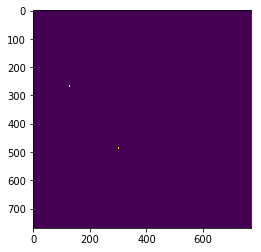

In [12]:
init_csvs([SAVE_DIR + 'negative_details.csv',
           SAVE_DIR + 'image_details.csv'])

crop_imageset(images,
              BLOBS_DIR,
              NEGATIVES,
              IMG_BBOXES)